In [1]:
import rasterio
from osgeo import gdal, ogr
from PIL import Image
import cv2 as cv
import glob
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import random
from rasterio.plot import show
from scipy.interpolate import griddata
from scipy.stats import norm

In [2]:

TP="TP2"

path = "/home/schnablelab/Documents/ImageDataset/SixBndImages/Lincoln/Hybrids/"+TP
print(path) 
def RGB(path):
    all_files=glob.glob(os.path.join(path, '*.TIF'))
    Color=[]
    for files in all_files:
        # print(files)
        dataset = gdal.Open(files)
        # print(dataset)
        numbands=dataset.RasterCount
        channels=[]
        R=[]
        G=[]
        B=[]
        NIR=[]
        RE=[]
        DB=[]
        if numbands!= 6:
            print("The Tif file doesnot have 6 bands.")
        
        else:
            channels = [dataset.GetRasterBand(i).ReadAsArray() for i in range(1, numbands+1)]
            # print(channels[0])
            (r,g,b,nir,re,db)=channels[0], channels[1], channels[2], channels[3], channels[4], channels[5]
            # print(r.tolist())
            
            for redrow in r:
                R.extend(redrow)
                
            for greenrow in g:
                G.extend(greenrow)
            
            for bluerow in b:
                B.extend(bluerow)
            
            for NIRrow in nir:
                NIR.extend(NIRrow)
            
            for rerow in re:
                RE.extend(rerow)
            
            for dbrow in db:
                DB.extend(dbrow)
                
        Image=os.path.basename(files).split('.')[0]

        Color.append(
            {'file':Image,
             'Red':sum(R)/len(R),
             'Green':sum(G)/len(G),
             'Blue':sum(B)/len(B),
             'NIR':sum(NIR)/len(NIR),
             'RedEdge':sum(RE)/len(RE),
             'DeepBlue':sum(DB)/len(DB)
            }
        )
        # print("done")
    RGB_values=pd.DataFrame(Color)
    return RGB_values

/home/schnablelab/Documents/ImageDataset/SixBndImages/Lincoln/Hybrids/TP2


In [3]:
def imagecrop(inputpath, crop_width, crop_height, outputpath):
    all_files=glob.glob(os.path.join(inputpath, '*.TIF'))
    # print(all_files)
    for file in all_files:
        with rasterio.open(file, 'r') as src:
            print(src.shape)
            
            if src.height > src.width:
                xmin, xmax = 0, src.width - crop_width
                ymin, ymax = 0, src.height - crop_height
                xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)
                window =  rasterio.windows.Window(xoff, yoff, crop_height, crop_width)
                
                transform = src.window_transform(window)
            
                profile = src.profile
                profile.update({
                    'height': crop_height,
                    'width': crop_width,
                    'transform': transform})
            elif src.width > src.height:
                # print(src.shape)
                height=crop_width
                width=crop_height
                # crop_height=width
                # print(crop_height,crop_width)
                xmin, xmax = 0, src.width - width
                ymin, ymax = 0, src.height - height
                xoff, yoff = random.randint(ymin, ymax), random.randint(xmin, xmax)
                window =  rasterio.windows.Window(xoff, yoff, height, width)
                
                transform = src.window_transform(window)
            
                profile = src.profile
                profile.update({
                    'height': height,
                    'width': width,
                    'transform': transform})
                # print(src.shape)
                    
            output_file = os.path.join(outputpath, f'{os.path.splitext(os.path.basename(file))[0]}_cropped.TIF')
            
            with rasterio.open(output_file, 'w', **profile) as dst:
                # Read the data from the window and write it to the output raster
                dst.write(src.read(window=window))
                # dst.fill.fillnodata()
                print(dst.shape)
            
            # print(org_width, org_height)
    
    

In [4]:
def bands(inputpath):
    all_files=glob.glob(os.path.join(inputpath, '*.TIF'))
    color=[]
    for file in all_files:
        with rasterio.open(file, 'r') as src:
            # print(src.shape)
            
            h=src.height
            w=src.width 
            
            Image=os.path.basename(file).split('.')[0]
            count=0
            for height in range(h):
                for width in range(w):
                    r,g,b,nir,re,db=src.read(1)[height,width],src.read(2)[height,width],src.read(3)[height,width],src.read(4)[height,width],src.read(5)[height,width],src.read(6)[height,width]
                    
                    GLI=(2*g-r-b)/(2*g+r+b)
                
                    NGRDIupper=g.astype(float)-r.astype(float)
                    NGRDIlower=g.astype(float)+r.astype(float)
                    NGRDI=(NGRDIupper.astype(float)/NGRDIlower.astype(float))
                    
                    NDVIupper=nir.astype(float)-r.astype(float)
                    NDVIlower=nir.astype(float)+r.astype(float)
                    NDVI=(NDVIupper.astype(float)/NDVIlower.astype(float))
                    
                    NDREupper=nir.astype(float)-re.astype(float)
                    NDRElower=nir.astype(float)+re.astype(float)
                    NDRE=(NDREupper.astype(float)/NDRElower.astype(float))
                    
                    color.append(
                        {'file':Image,
                         'Red':r,
                         'Green':g,
                         'Blue':b,
                         'GLI':GLI,
                         'NGRDI':NGRDI,
                         'NDVI':NDVI,
                         'NDRE':NDRE,
                         'RedEdge':re,
                         'DeepBlue':db
                        } 
                    )
                    # count+=1
                    # print(count)
    band_values=pd.DataFrame(color)
    return band_values    

In [67]:
banddf=bands(inputpath="../ImageDataset/SixBndImages/Crawfordsville/Hybrids/CroppedTP6/")

/tmp/ipykernel_311114/1886702823.py:17: RuntimeWarning: invalid value encountered in scalar divide
  GLI=(2*g-r-b)/(2*g+r+b)
/tmp/ipykernel_311114/1886702823.py:21: RuntimeWarning: invalid value encountered in scalar divide
  NGRDI=(NGRDIupper.astype(float)/NGRDIlower.astype(float))
/tmp/ipykernel_311114/1886702823.py:25: RuntimeWarning: invalid value encountered in scalar divide
  NDVI=(NDVIupper.astype(float)/NDVIlower.astype(float))
/tmp/ipykernel_311114/1886702823.py:29: RuntimeWarning: invalid value encountered in scalar divide
  NDRE=(NDREupper.astype(float)/NDRElower.astype(float))


(array([7.474e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        2.000e+00]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 3.956e+03, 3.957e+03,
        3.958e+03]),
 <BarContainer object of 3958 artists>)

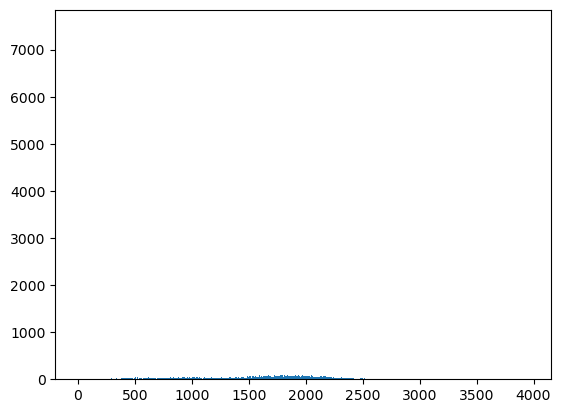

In [68]:
plt.hist(banddf["Red"], bins=range(min(banddf["Red"]), max(banddf["Red"]) + 2),align='left', rwidth=100)

In [69]:
banddf.describe()

,Red,Green,Blue,GLI,NGRDI,NDVI,NDRE,RedEdge,DeepBlue
count,102800.000000,102800.000000,102800.000000,95326.000000,95326.000000,95326.000000,95326.000000,102800.000000,102800.000000
mean,1437.002471,1026.523930,771.531304,-0.030879,-0.157063,0.243346,0.100131,1843.122237,617.480175
std,703.360495,481.063647,359.498824,0.025693,0.037562,0.078225,0.011547,777.728630,258.205265
min,0.000000,0.000000,0.000000,-0.111402,-0.241611,0.113291,0.032554,0.000000,0.000000
25%,927.000000,690.000000,530.000000,-0.044713,-0.176753,0.196472,0.092642,1339.000000,471.000000
50%,1611.000000,1147.000000,857.000000,-0.035987,-0.166513,0.217963,0.099816,2053.000000,679.000000
75%,1961.000000,1381.000000,1035.000000,-0.024725,-0.151153,0.260996,0.107455,2407.000000,800.000000
max,3957.000000,2743.000000,2103.000000,0.299145,0.640288,0.919872,0.160912,4242.000000,1579.000000


In [70]:
banddf=banddf.loc[banddf['Red']>=0.001]
banddf=banddf.loc[banddf['Red']<=3000]

(array([2., 0., 0., ..., 2., 0., 4.]),
 array([  25.,   26.,   27., ..., 2999., 3000., 3001.]),
 <BarContainer object of 2976 artists>)

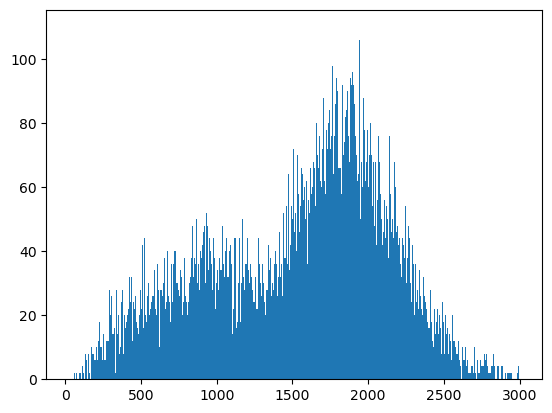

In [71]:
plt.hist(banddf["Red"], bins=range(min(banddf["Red"]), max(banddf["Red"]) + 2),align='left', rwidth=10)

In [72]:
banddf=banddf.groupby('file')[["Red", "Green", "Blue", 'GLI', 'NGRDI','NDVI','NDRE','RedEdge','DeepBlue']].agg(['mean', 'median', 'sum']).reset_index()
banddf.columns = banddf.columns.map('_'.join)

In [73]:
banddf.describe()

,Red_mean,Red_median,Red_sum,Green_mean,Green_median,Green_sum,Blue_mean,Blue_median,Blue_sum,GLI_mean,...,NDVI_sum,NDRE_mean,NDRE_median,NDRE_sum,RedEdge_mean,RedEdge_median,RedEdge_sum,DeepBlue_mean,DeepBlue_median,DeepBlue_sum
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,...,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,1546.087407,1568.657588,285798.424125,1104.623364,1119.283074,204198.066148,830.128740,841.959144,153459.661479,-0.030810,...,45.058437,0.100093,0.100577,18.519980,1984.528185,2005.534047,366871.883268,664.635327,672.295720,122872.871595
std,237.655782,246.559690,46642.568047,162.431546,168.620189,32126.439952,106.194361,111.567859,21441.517362,0.008276,...,5.212299,0.006722,0.006976,1.808205,293.391345,297.326891,58008.913746,62.310926,65.769749,13483.371899
min,1098.822222,988.000000,197788.000000,816.155556,711.000000,144128.000000,634.988889,537.000000,109100.000000,-0.059064,...,33.429055,0.079585,0.080227,12.935097,1449.888889,1334.500000,259772.000000,545.800000,462.000000,91448.000000
25%,1359.230732,1391.500000,249798.500000,973.940543,995.250000,180318.000000,745.934643,761.625000,137218.500000,-0.036378,...,40.922071,0.095415,0.095818,17.172082,1758.851852,1785.625000,321074.000000,616.633333,626.000000,113209.000000
50%,1451.717299,1523.750000,273523.000000,1041.222222,1090.500000,195415.000000,791.742021,833.250000,148795.000000,-0.030988,...,45.172554,0.099608,0.100237,18.364102,1861.283889,1926.500000,350246.000000,643.068333,671.000000,121651.000000
75%,1799.895177,1801.750000,322883.000000,1280.455278,1281.250000,230154.000000,942.503853,944.000000,170935.500000,-0.025591,...,49.100015,0.104358,0.105101,19.721684,2292.477778,2298.750000,415611.500000,725.528226,725.875000,132591.500000
max,2124.344444,2130.000000,404154.000000,1504.555556,1504.500000,289624.000000,1084.544444,1085.500000,212424.000000,-0.001307,...,60.316008,0.127898,0.127979,23.410462,2737.159574,2733.000000,517748.000000,802.978723,815.500000,158502.000000


In [74]:
banddf

,file_,Red_mean,Red_median,Red_sum,Green_mean,Green_median,Green_sum,Blue_mean,Blue_median,Blue_sum,...,NDVI_sum,NDRE_mean,NDRE_median,NDRE_sum,RedEdge_mean,RedEdge_median,RedEdge_sum,DeepBlue_mean,DeepBlue_median,DeepBlue_sum
0,Crawfordsville-TP6-4351_10_13,1483.020000,1509.0,296604,1083.170000,1111.5,216634,826.570000,843.0,165314,...,49.960840,0.096589,0.098320,19.317719,1892.920000,1917.0,378584,640.840000,652.0,128168
1,Crawfordsville-TP6-4351_10_14,1312.570000,1348.5,262514,929.960000,955.0,185992,725.980000,744.5,145196,...,54.152652,0.106478,0.106633,21.295557,1751.400000,1785.5,350280,590.440000,609.5,118088
2,Crawfordsville-TP6-4351_10_15,1544.300000,1628.0,277974,1094.144444,1130.5,196946,822.366667,868.5,148026,...,42.171648,0.094869,0.095329,17.076436,1938.955556,2018.0,349012,649.666667,679.0,116940
3,Crawfordsville-TP6-4351_10_16,1327.970000,1221.0,265594,953.340000,850.0,190668,737.100000,660.0,147420,...,50.809636,0.104543,0.106501,20.908596,1705.850000,1587.0,341170,617.760000,581.5,123552
4,Crawfordsville-TP6-4351_10_17,1296.546512,1159.0,223006,936.313953,830.0,161046,707.337209,642.0,121662,...,53.644154,0.092301,0.094492,15.875806,1793.139535,1596.5,308420,596.883721,555.5,102664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,Crawfordsville-TP6-4353_9_42,2020.770000,1978.5,404154,1448.120000,1423.0,289624,1061.900000,1043.0,212380,...,41.670418,0.095380,0.094374,19.076049,2533.290000,2466.5,506658,785.860000,769.5,157172
510,Crawfordsville-TP6-4353_9_43,1898.902174,1911.5,349398,1336.467391,1340.5,245910,976.054348,967.5,179594,...,40.359175,0.089079,0.090028,16.390472,2466.673913,2471.0,453868,739.402174,742.5,136050
511,Crawfordsville-TP6-4353_9_44,1924.788889,1940.5,346462,1368.500000,1383.5,246330,976.088889,983.5,175696,...,38.111572,0.092711,0.093055,16.688028,2447.366667,2456.0,440526,738.722222,748.5,132970
512,Crawfordsville-TP6-4353_9_45,1839.980000,1867.5,367996,1302.220000,1302.0,260444,945.200000,961.0,189040,...,43.510442,0.093726,0.094867,18.745269,2354.330000,2372.5,470866,725.750000,727.5,145150


In [75]:
banddf.to_csv("SatelliteImage_6bands_TP6.csv",index=False)

In [5]:
# imagecrop(inputpath="../ImageDataset/SixBndImages/Lincoln/Hybrids/TP2/", crop_width=10, crop_height=20, outputpath="/home/schnablelab/Documents/ImageDataset/SixBndImages/Lincoln/Hybrids/CroppedTP2/")

In [44]:
imagecrop(inputpath="/home/schnablelab/Documents/ImageDataset/SixBndImages/Lincoln/TP2", crop_width=10, crop_height=20, outputpath="/home/schnablelab/Documents/ImageDataset/SixBndImages/Lincoln/Hybrids/CroppedTP2/")

In [84]:
def norm(array):
    # Min-max normalization
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

def show_random_images(inputpath, num_files):
    all_files = glob.glob(os.path.join(inputpath, '*.TIF'))
    
    random_files=random.sample(all_files, num_files)
    for file in random_files:
        print(file)
        with rasterio.open(file, 'r') as src:
            S_images=src.read()
            print(S_images.shape)
            # print(src.nodata)
            # print(S_images[0])
            b2 = norm(S_images[0].astype(np.float32))
            b3 = norm(S_images[1].astype(np.float32))
            b4 = norm(S_images[2].astype(np.float32))

    # Create RGB
            rgb = np.dstack((b4,b3,b2))
            print(rgb.shape)

    # Visualize RGB
            
            plt.imshow(rgb)
            plt.axis('off')
            # plt.savefig(f'{os.path.splitext(os.path.basename(file))[0]}_rgb.png', dpi=300, bbox_inches='tight', pad_inches=0)
            plt.show()
            # plt.savefig(f'{os.path.splitext(os.path.basename(file))[0]}_rgb.png')
    
show_random_images(inputpath="/home/schnablelab/Documents/ImageDataset/SixBndImages/Crawfordsville/Hybrids/CroppedTP5/", num_files=5)

In [6]:
RGBvalues=RGB(path)
RGBvalues[['field', 'range', 'row']]=RGBvalues["file"].str.split('_', expand=True)
pca = PCA(n_components=3)
embedding = pca.fit_transform(RGBvalues[["Red", "Green", "Blue", "NIR", "RedEdge", "DeepBlue"]].T)
PCAdf=pd.DataFrame(pca.components_.T)
PCAdf.columns=[["PC1", "PC2", "PC3"]]
RGBvalues=pd.concat([RGBvalues, PCAdf], axis=1)
new_column_names = {('PC1',): "PC1",('PC2',): "PC2",('PC3',): "PC3"}

# Rename the columns using the dictionary
RGBvalues = RGBvalues.rename(columns=new_column_names)

In [7]:
Hipsdf=pd.read_csv("/home/schnablelab/Documents/NNSatelliteImages/Data/HYBRID_HIPS_V3.5_ALLPLOTS.csv", sep=",")
Hipsdf=Hipsdf.loc[Hipsdf["location"]=="Crawfordsville",]
Hipsdf.columns
# Hipsdf["row"].value_counts()

Index(['Unnamed: 0', 'qrCode', 'location', 'sublocation', 'irrigationProvided',
       'nitrogenTreatment', 'poundsOfNitrogenPerAcre', 'experiment',
       'plotLength', 'totalStandCount', 'block', 'row', 'range', 'plotNumber',
       'genotype', 'plantingDate', 'anthesisDate', 'silkDate',
       'daysToAnthesis', 'daysToSilk', 'anthesisSilkingInterval',
       'GDDToAnthesis', 'GDDToSilk', 'anthesisSilkingIntervalGDD', 'earHeight',
       'flagLeafHeight', 'plantDensity', 'combineYield', 'yieldPerAcre',
       'combineMoisture', 'combineTestWeight', 'earLength', 'earFillLength',
       'earWidth', 'shelledCobWidth', 'kernelsPerRow', 'kernelRowNumber',
       'kernelsPerEar', 'hundredKernelMass', 'kernelMassPerEar',
       'shelledCobMass', 'percentMoisture', 'percentStarch', 'percentProtein',
       'percentOil', 'percentFiber', 'percentAsh', 'kernelColor',
       'percentLodging', 'harvestDate', 'notes', 'rangeRow'],
      dtype='object')

In [8]:
Hipsdf

,Unnamed: 0,qrCode,location,sublocation,irrigationProvided,nitrogenTreatment,poundsOfNitrogenPerAcre,experiment,plotLength,totalStandCount,...,percentStarch,percentProtein,percentOil,percentFiber,percentAsh,kernelColor,percentLodging,harvestDate,notes,rangeRow
487,487,22-C-1584342,Crawfordsville,Crawfordsville A,0.0,Low,75.0,LC_4352,17.5,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-10-07,Check,13-2
488,488,22-C-1584343,Crawfordsville,Crawfordsville A,0.0,Low,75.0,LC_4352,17.5,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-10-07,Check,13-3
489,489,22-C-1584344,Crawfordsville,Crawfordsville A,0.0,Low,75.0,LC_4352,17.5,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,25.0,2022-10-07,Check,13-4
490,490,22-C-1584345,Crawfordsville,Crawfordsville A,0.0,Low,75.0,LC_4352,17.5,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-10-07,Check,13-5
491,491,22-C-1584346,Crawfordsville,Crawfordsville A,0.0,Low,75.0,LC_4352,17.5,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-10-07,Severe bend in ear. String used to measure ear...,13-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,2,NaN,Crawfordsville,NaN,NaN,NaN,NaN,LC_4353,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7-42
3770,3,NaN,Crawfordsville,NaN,NaN,NaN,NaN,LC_4353,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7-45
3771,4,NaN,Crawfordsville,NaN,NaN,NaN,NaN,LC_4353,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10-44
3772,5,NaN,Crawfordsville,NaN,NaN,NaN,NaN,LC_4353,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16-42


In [9]:
for index1, row1 in RGBvalues.iterrows():
    file=row1['field']
    field=int(file.split("-")[2])
    try:
        range1 = int(row1["range"])
    except ValueError:
        print(f"Unable to convert 'range1' for index {index1} to an integer.")
        continue
    rownum=int(row1["row"])
            
    
    for index2, row2 in Hipsdf.iterrows():
        field2=int(row2["experiment"].split("_")[1])
        range2=row2["range"]
        row_2=row2["row"]
        
        if field==field2 and range1==range2 and rownum==row_2:
            RGBvalues.at[index1, "plantDensity"]=row2["plantDensity"]
            RGBvalues.at[index1, 'combineYield']=row2["combineYield"]
            RGBvalues.at[index1, 'yieldPerAcre']=row2["yieldPerAcre"]
            RGBvalues.at[index1, 'totalStandCount']=row2["totalStandCount"]
            RGBvalues.at[index1, 'daysToAnthesis']=row2["daysToAnthesis"]
            RGBvalues.at[index1, 'GDDToAnthesis']=row2["GDDToAnthesis"]
            RGBvalues.at[index1, 'daysToSilk']=row2["daysToSilk"]
            RGBvalues.at[index1, 'GDDToSilk']=row2["GDDToSilk"]
            RGBvalues.at[index1, 'percentMoisture']=row2["percentMoisture"]
            RGBvalues.at[index1, 'percentStarch']=row2["percentStarch"]
            RGBvalues.at[index1, 'percentProtein']=row2["percentProtein"]
            RGBvalues.at[index1, 'percentOil']=row2["percentOil"]
            RGBvalues.at[index1, 'percentFiber']=row2["percentFiber"]
            RGBvalues.at[index1, 'percentAsh']=row2["percentAsh"]
            RGBvalues.at[index1, 'percentLodging']=row2["percentLodging"]
            RGBvalues.at[index1, 'flagLeafHeight']=row2["flagLeafHeight"]
RGBvalues['file']=RGBvalues['file']+'_cropped.TIF'

RGBvalues.to_csv("HipsData_"+TP+"_CrawFordsville.csv", index=False)

In [13]:
RGBvalues=RGBvalues[['file','yieldPerAcre']]

In [15]:
RGBvalues.to_csv("HipsData_"+TP+"_CrawFordsville_yield.csv", index=False)

In [11]:
RGBvalues.columns

Index(['file', 'Red', 'Green', 'Blue', 'NIR', 'RedEdge', 'DeepBlue', 'field',
       'range', 'row', 'PC1', 'PC2', 'PC3', 'plantDensity', 'combineYield',
       'yieldPerAcre', 'totalStandCount', 'daysToAnthesis', 'GDDToAnthesis',
       'daysToSilk', 'GDDToSilk', 'percentMoisture', 'percentStarch',
       'percentProtein', 'percentOil', 'percentFiber', 'percentAsh',
       'percentLodging', 'flagLeafHeight'],
      dtype='object')

In [287]:
new_column_names=RGBvalues.columns[[13,14,15,16,27,28,1,2,3,4,5,6,10,11,12]]
print(len(new_column_names))

15


Red
Red
Red
Red
Red
Red
Green
Green
Green
Green
Green
Green
Blue
Blue
Blue
Blue
Blue
Blue
NIR
NIR
NIR
NIR
NIR
NIR
RedEdge
RedEdge
RedEdge
RedEdge
RedEdge
RedEdge
DeepBlue
DeepBlue
DeepBlue
DeepBlue
DeepBlue
DeepBlue
PC1
PC1
PC1
PC1
PC1
PC1
PC2
PC2
PC2
PC2
PC2
PC2
PC3
PC3
PC3
PC3
PC3
PC3


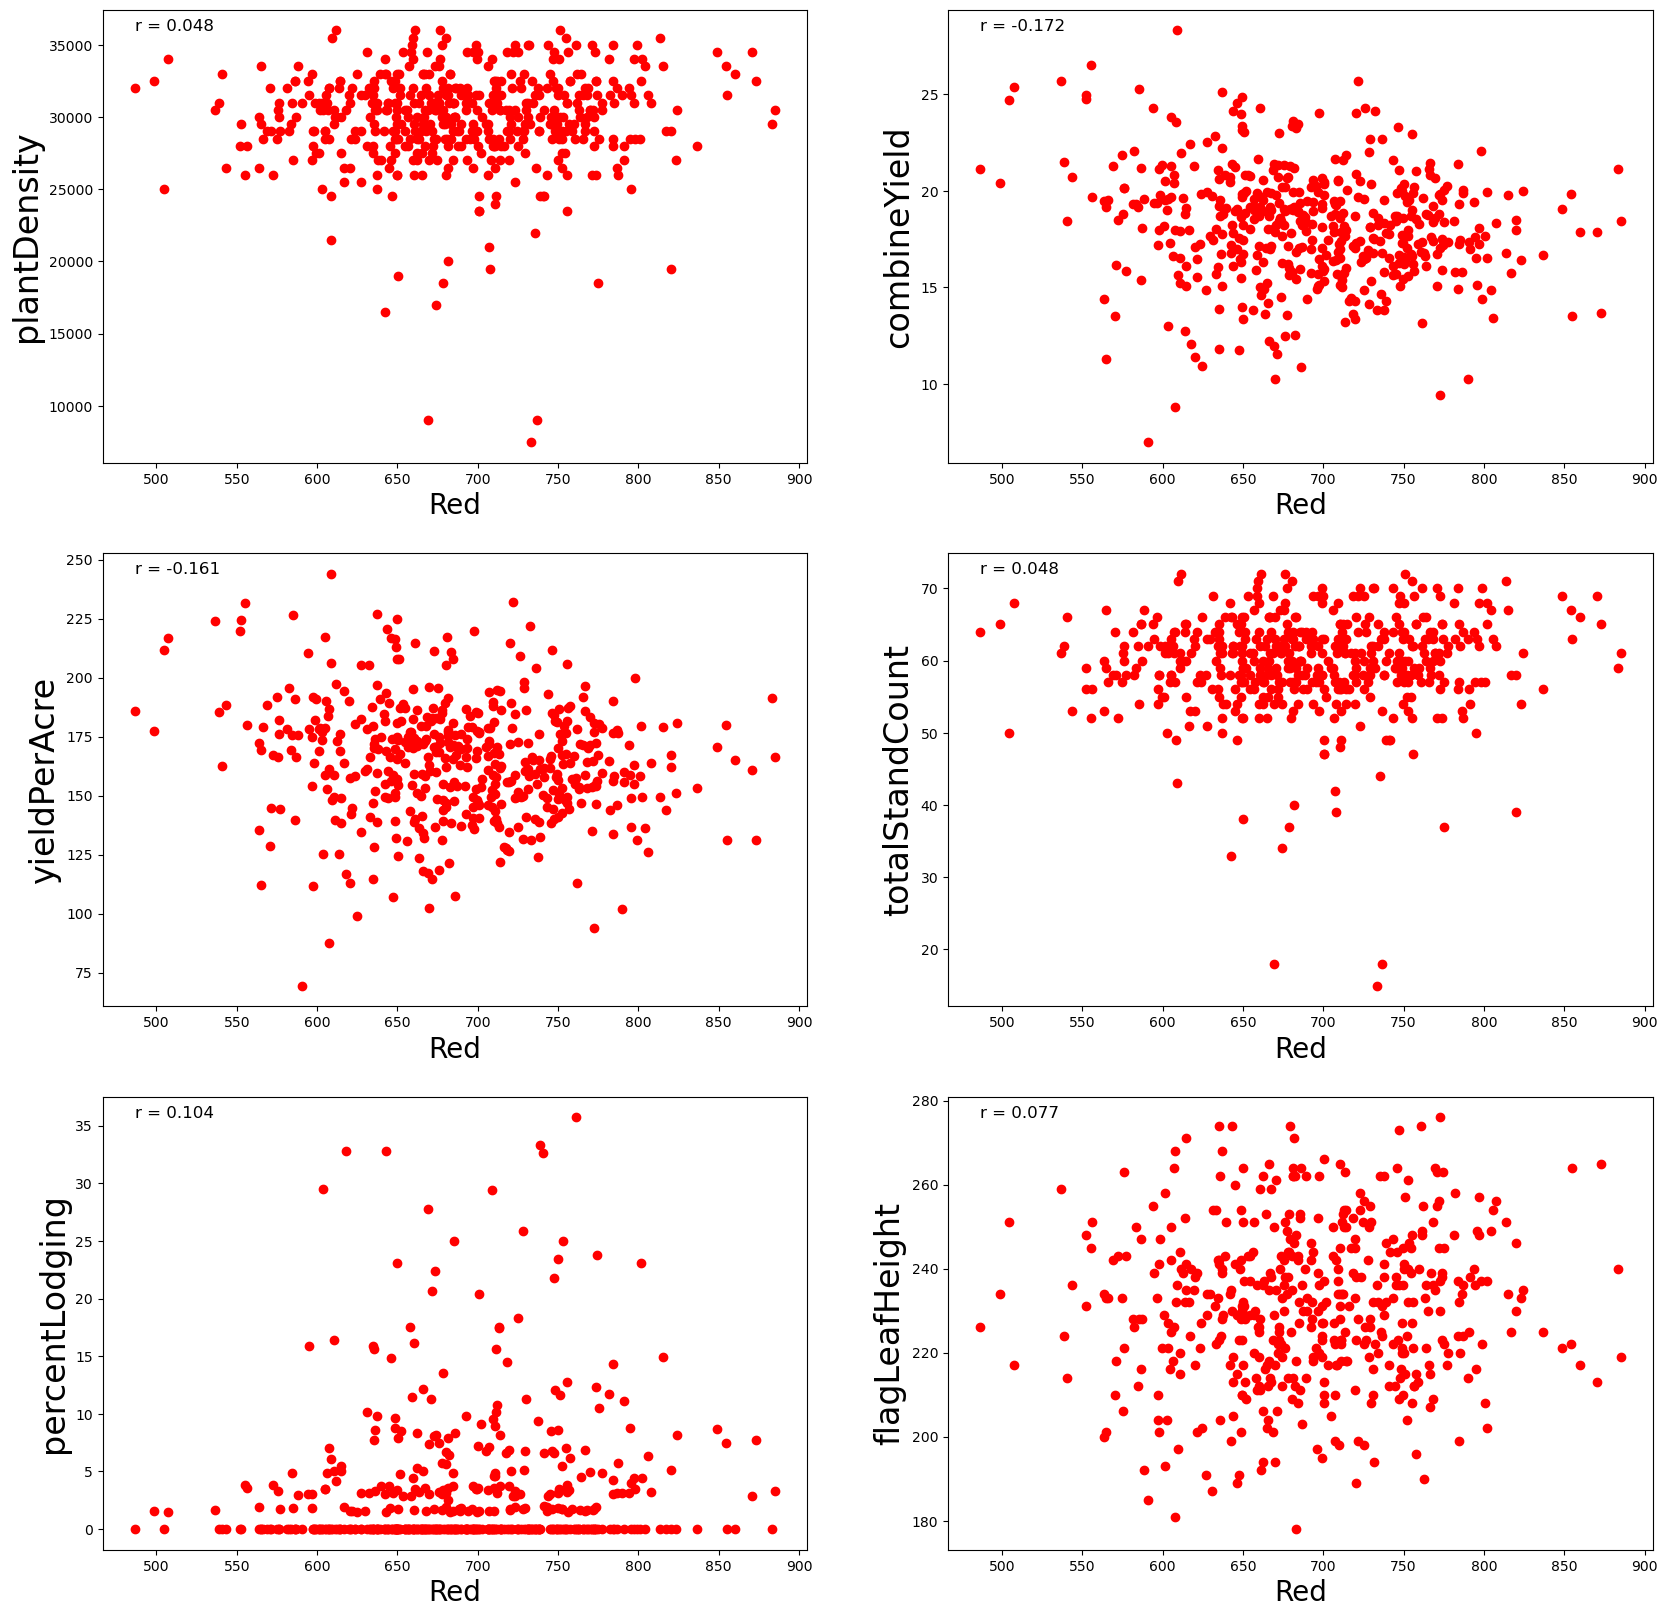

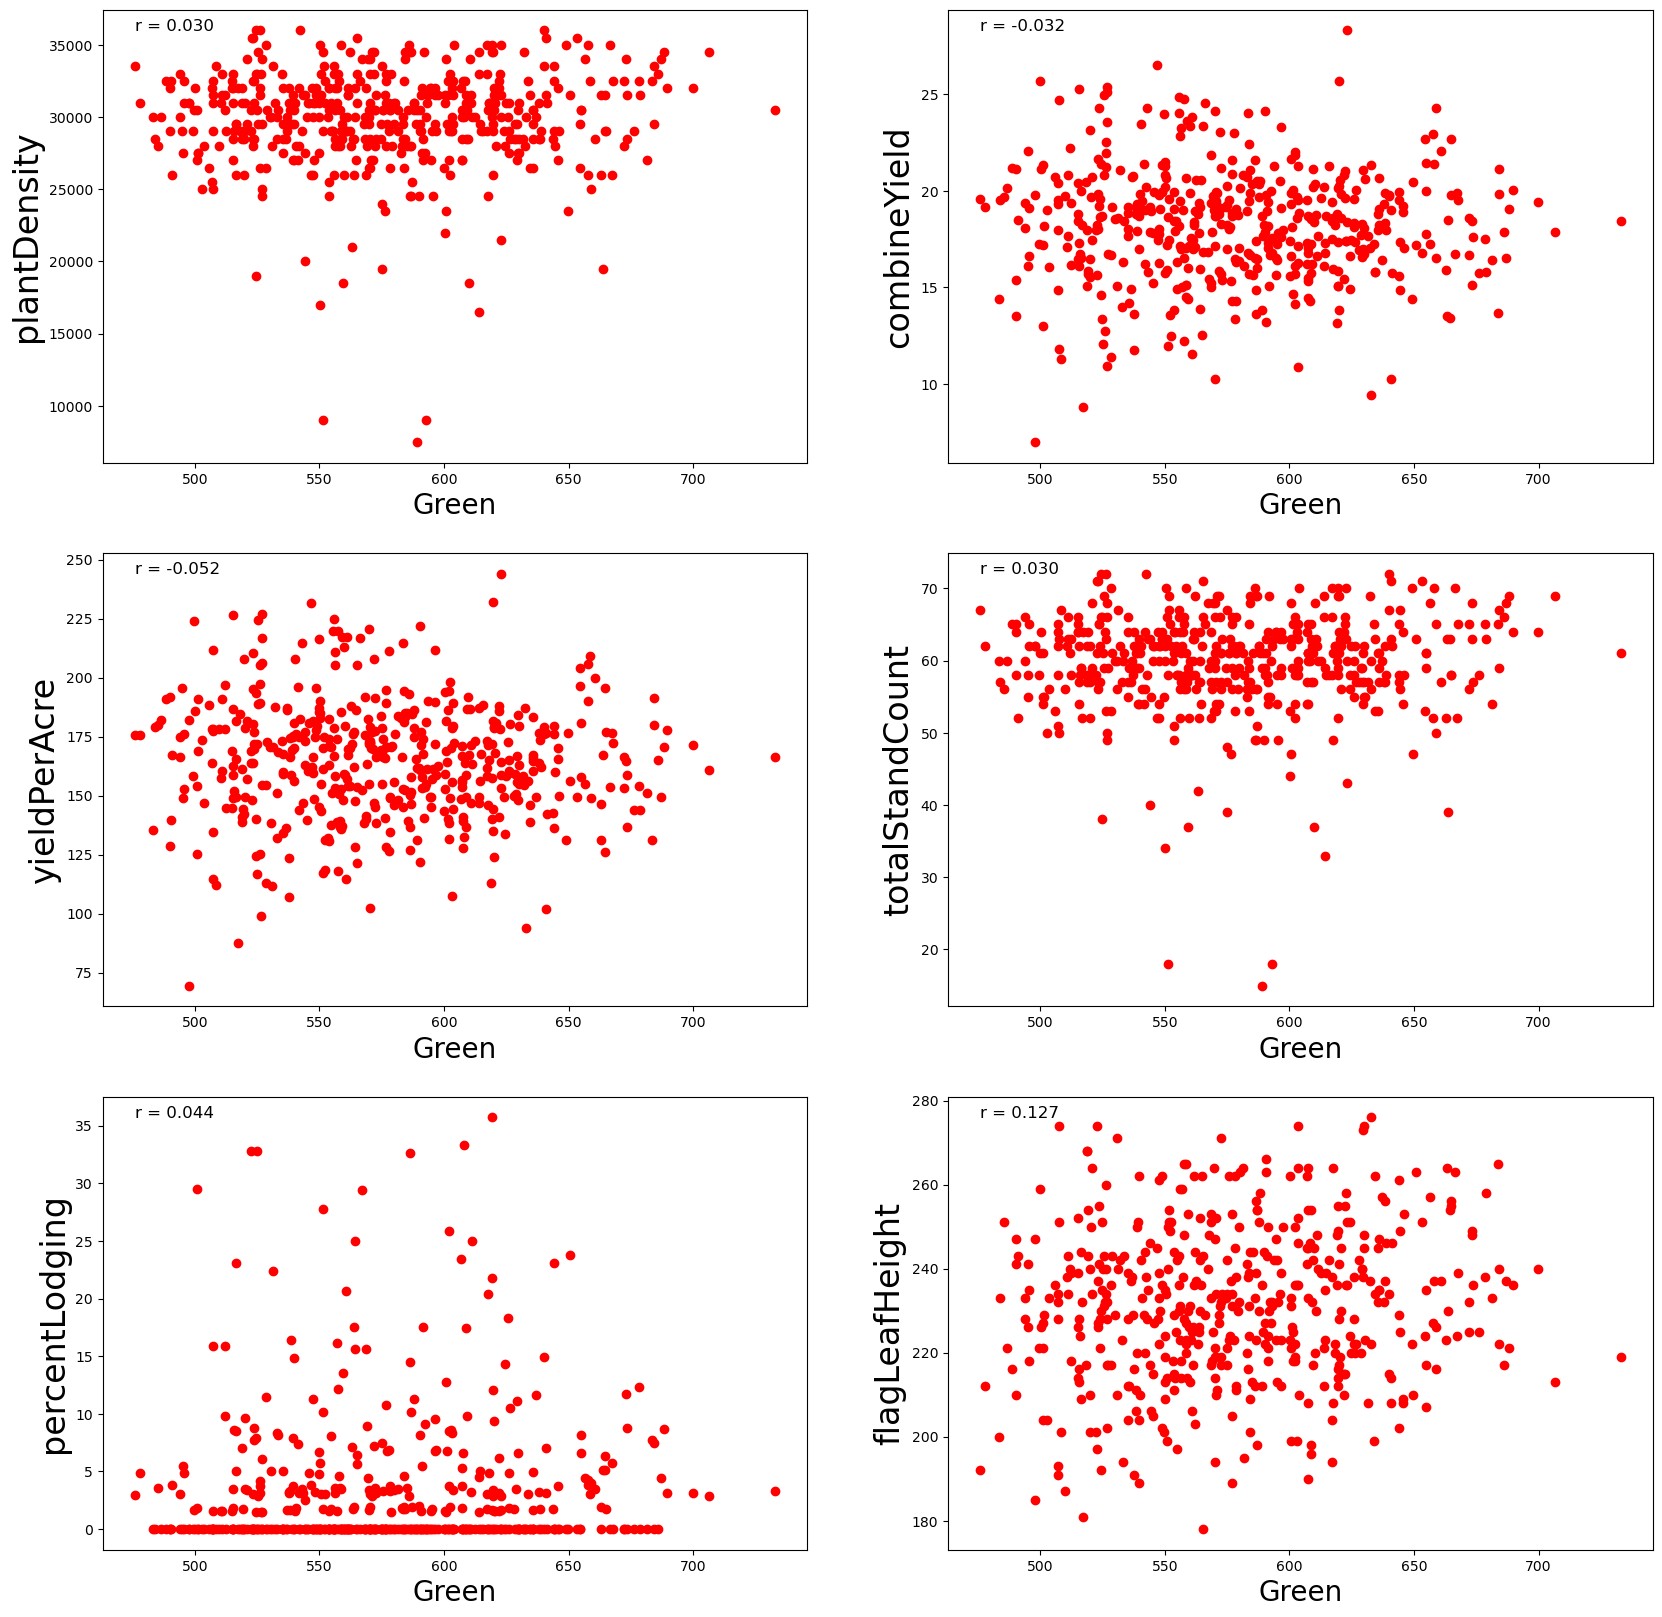

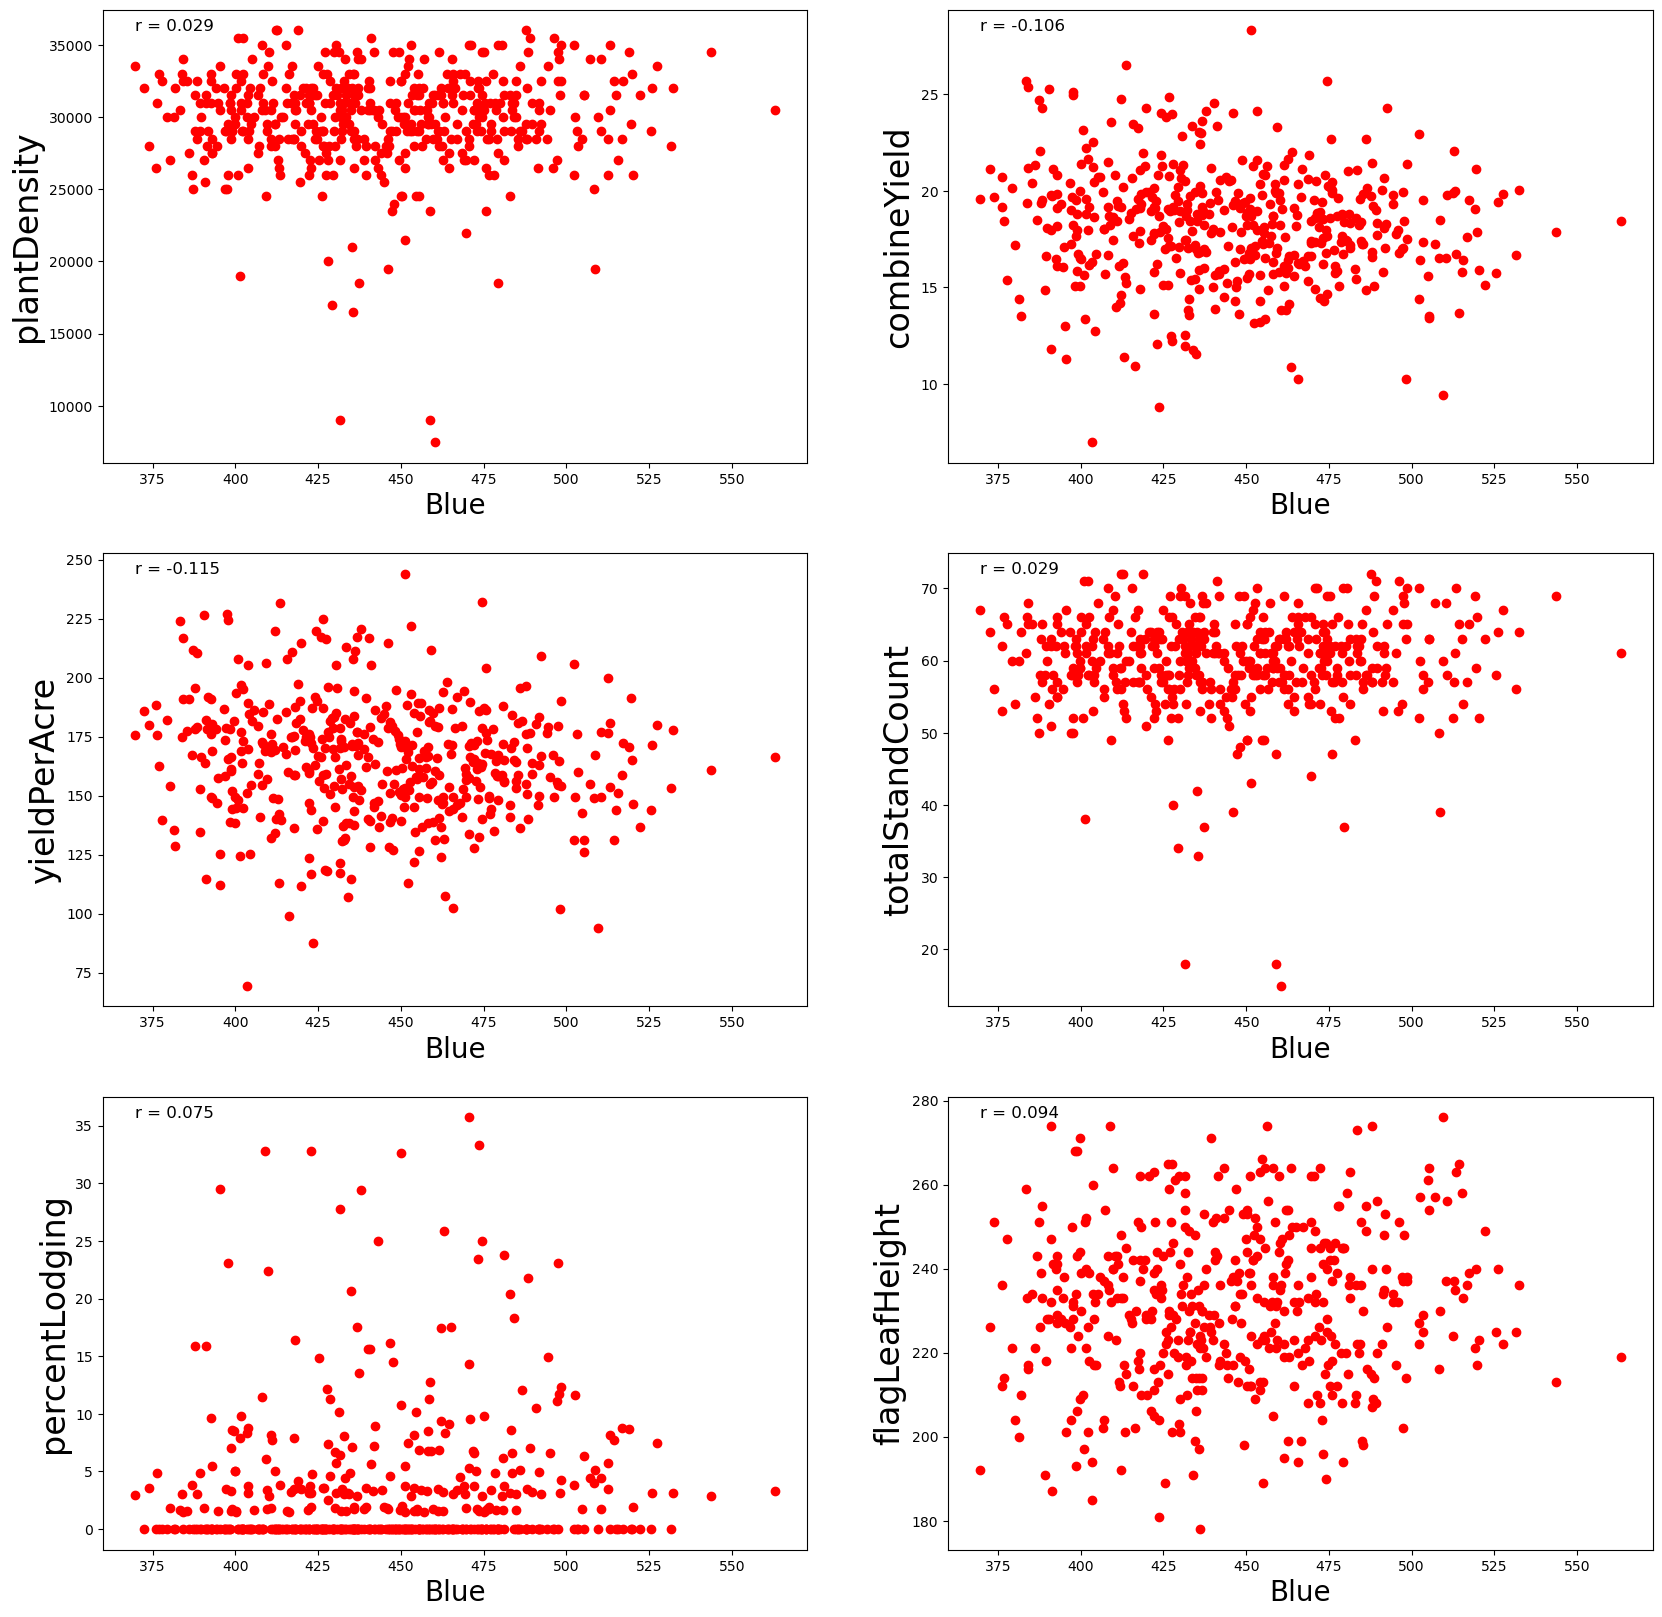

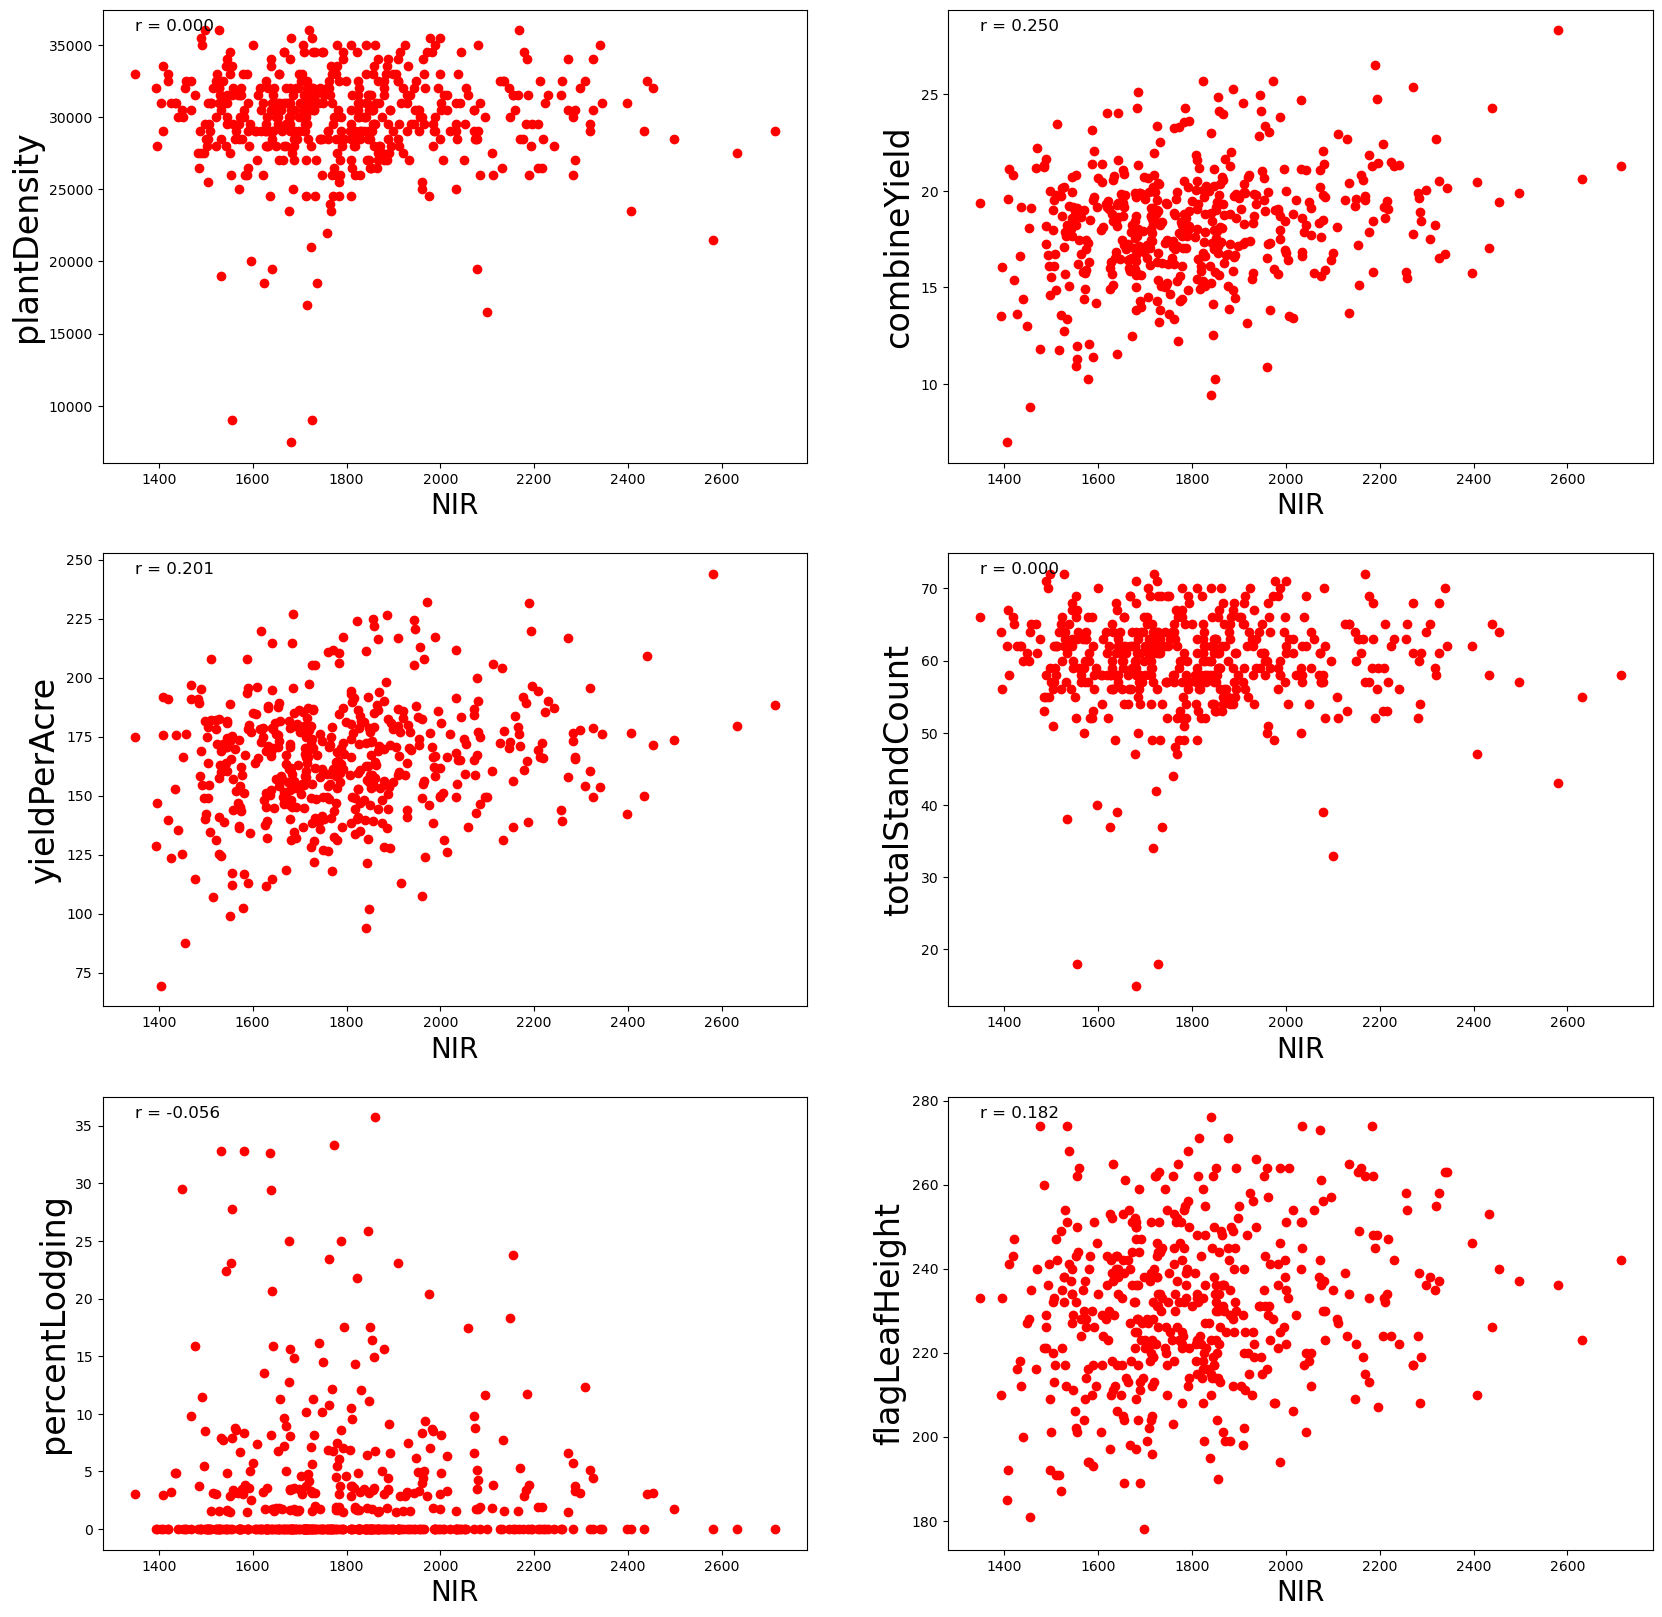

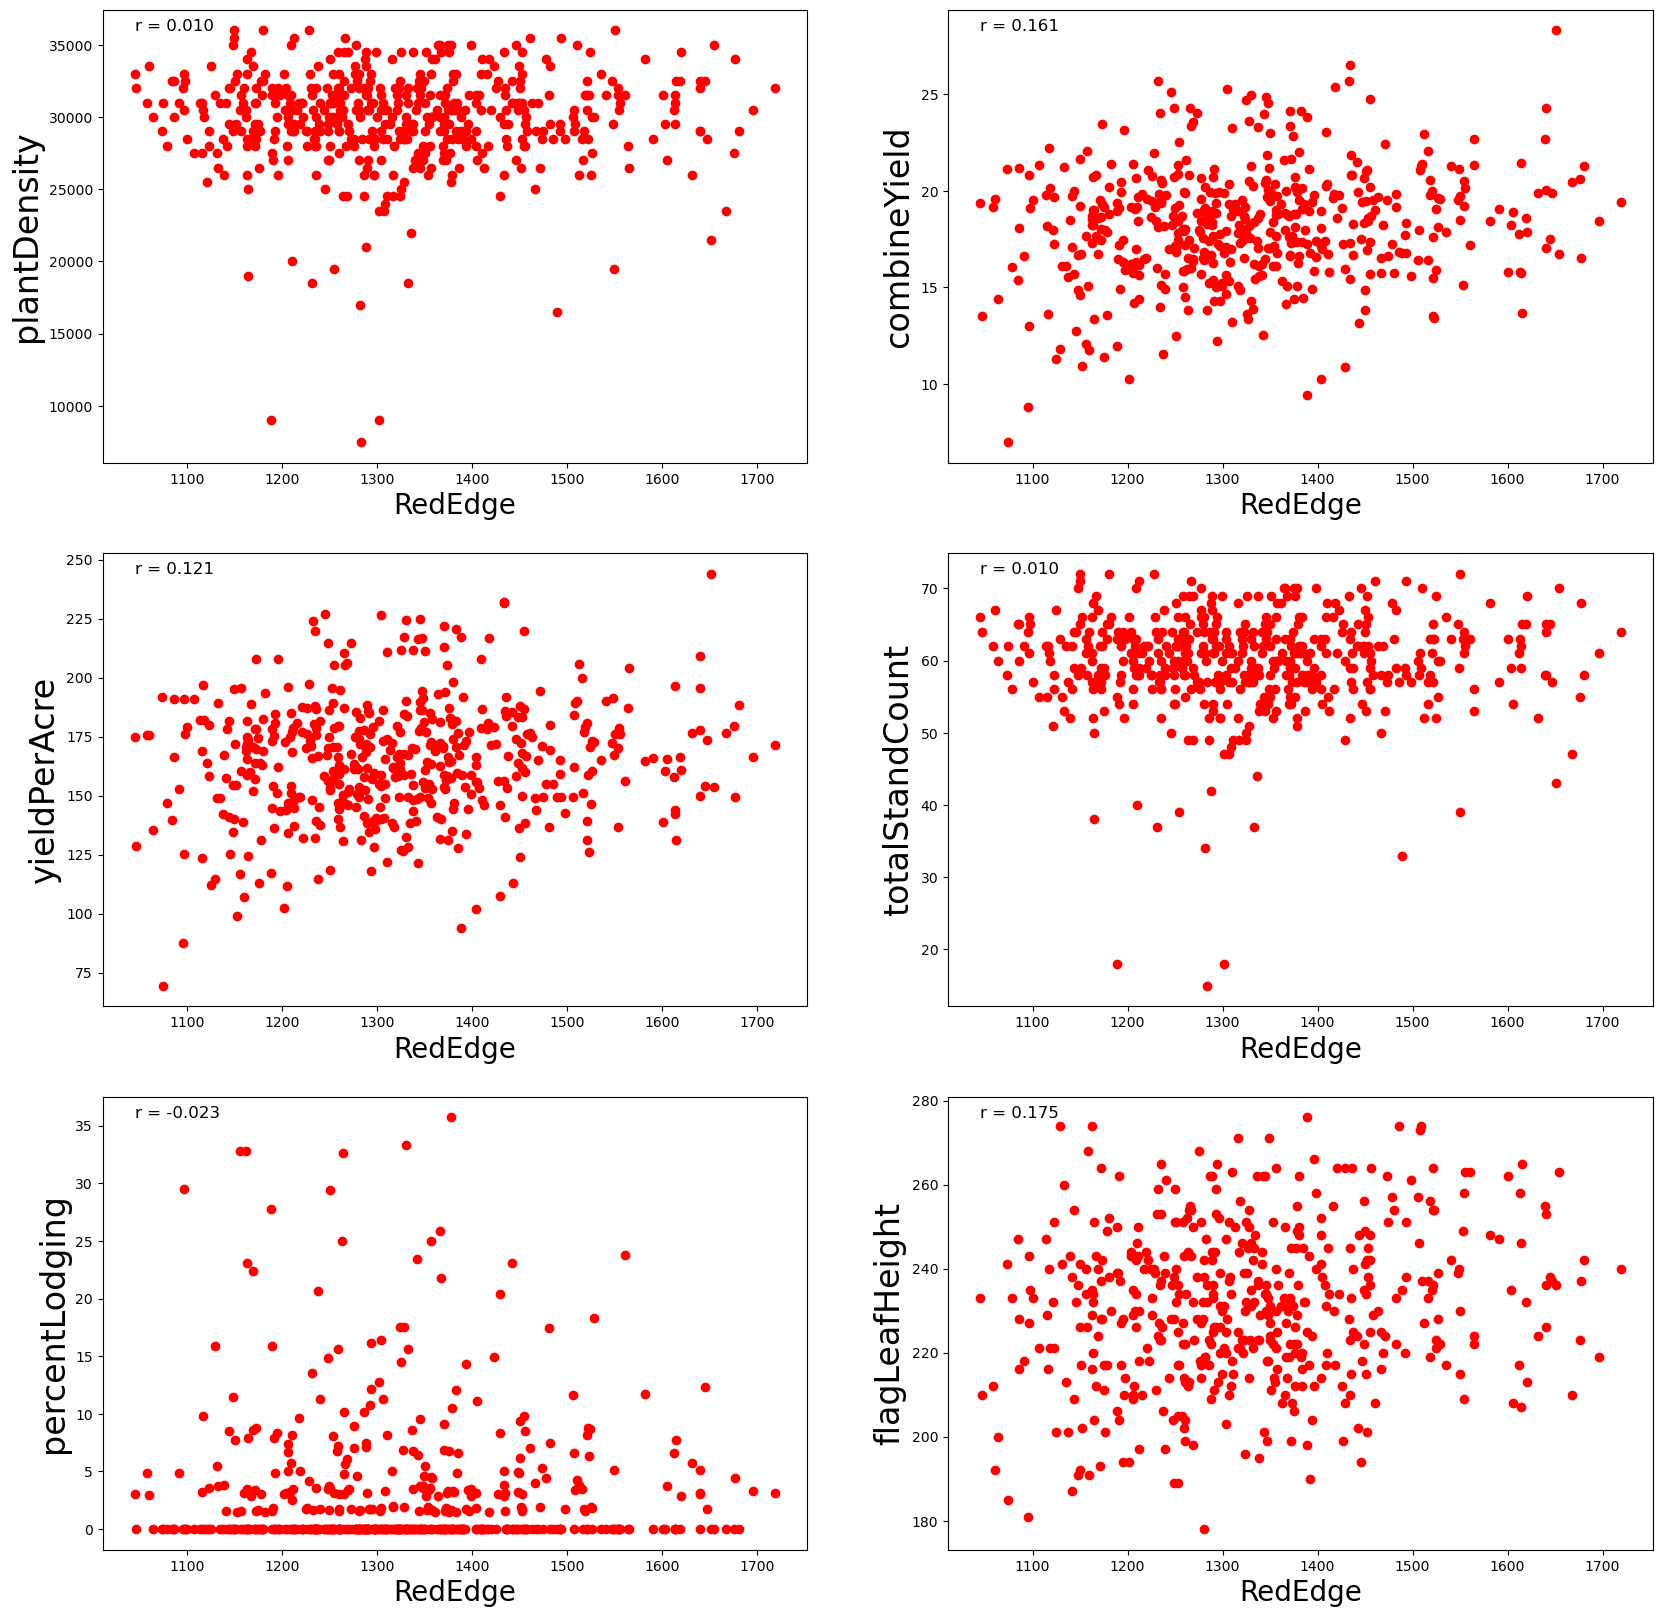

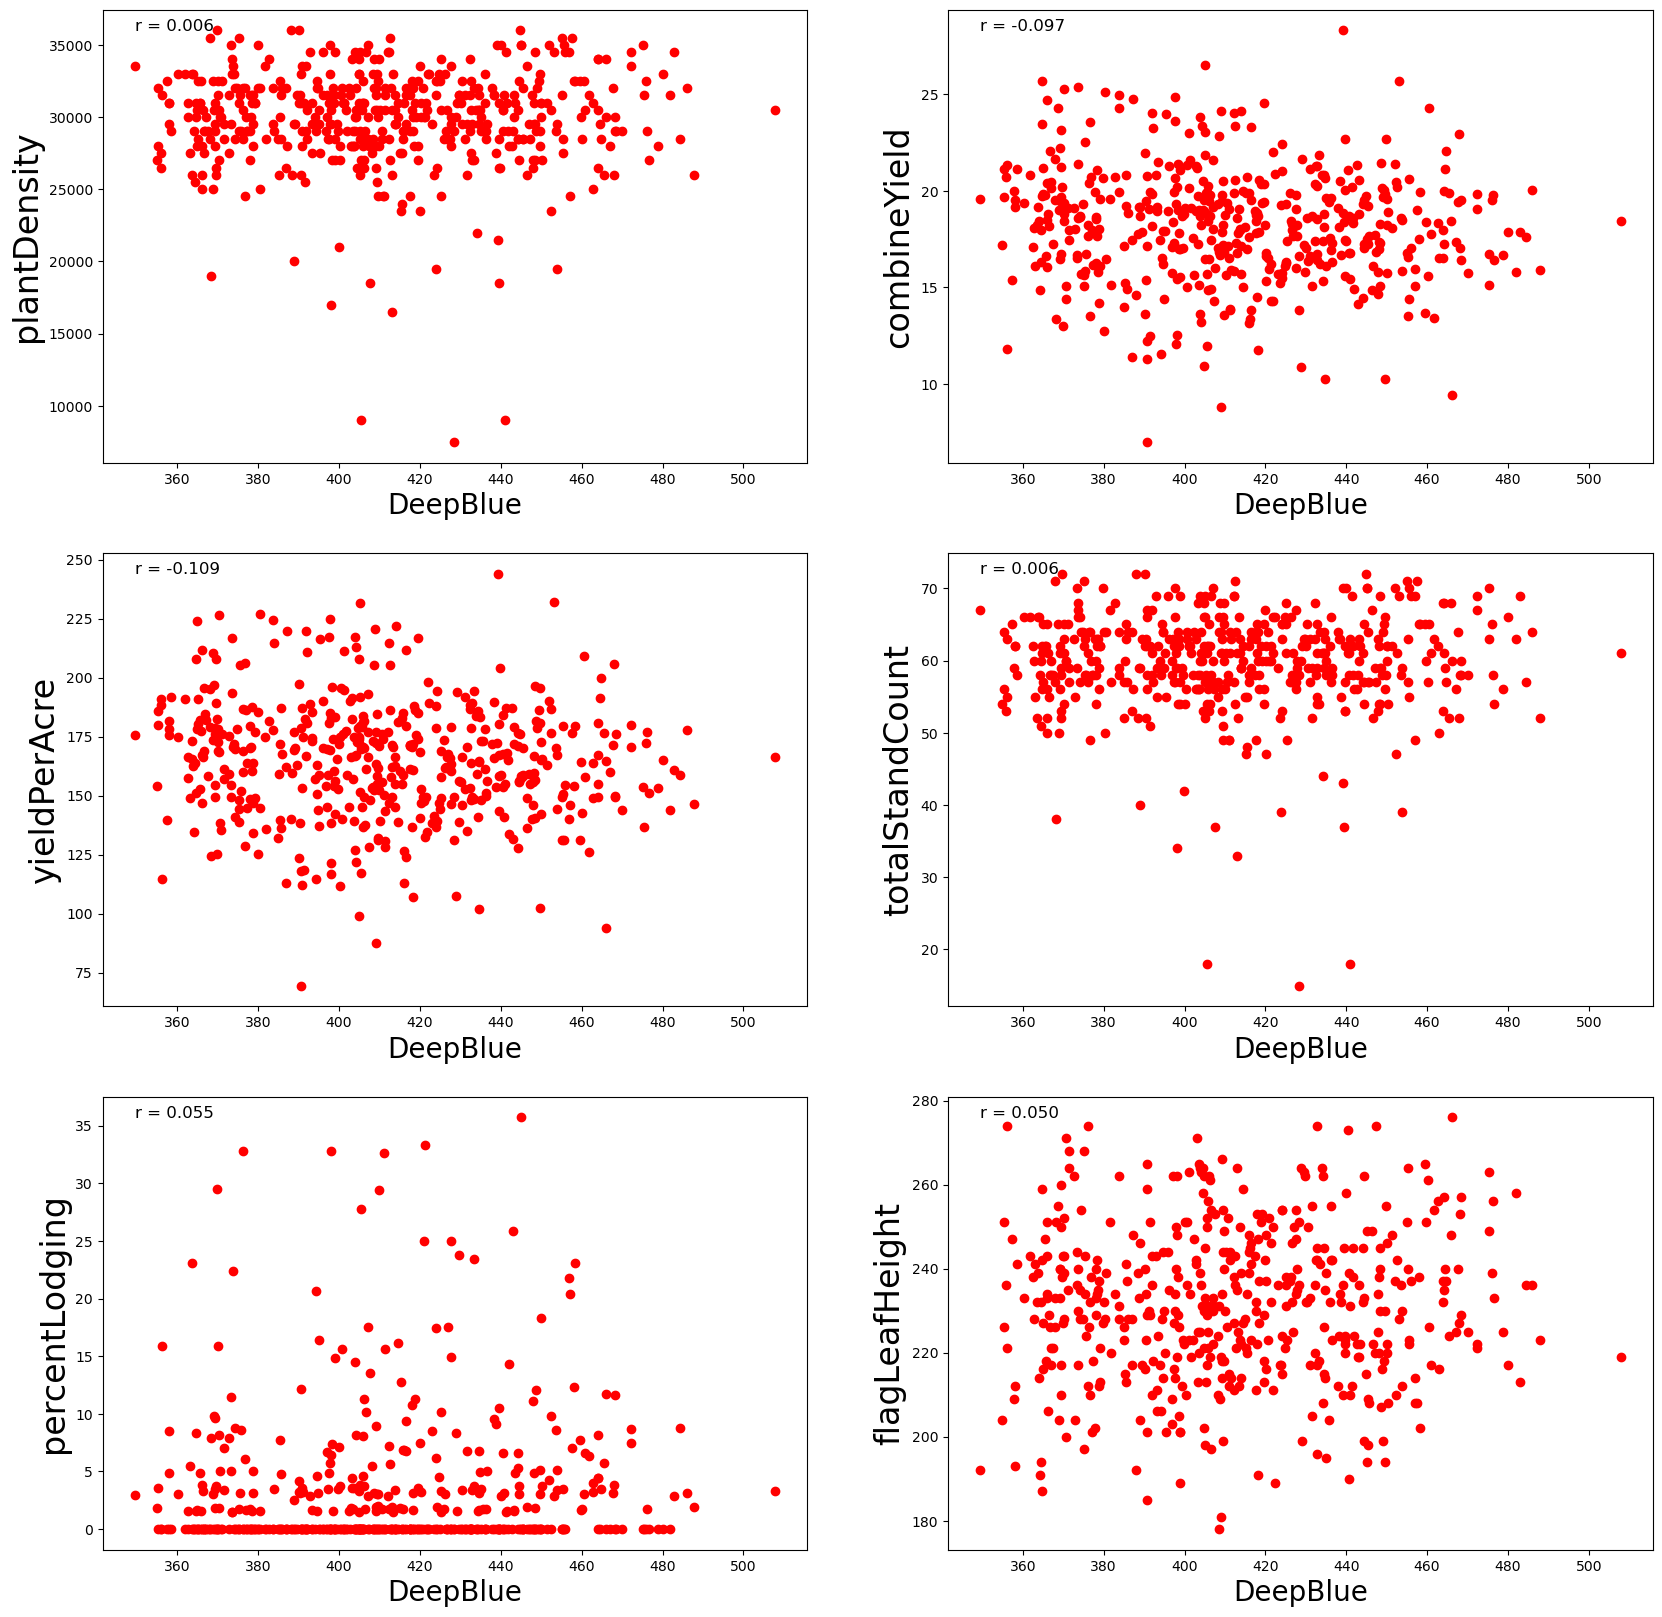

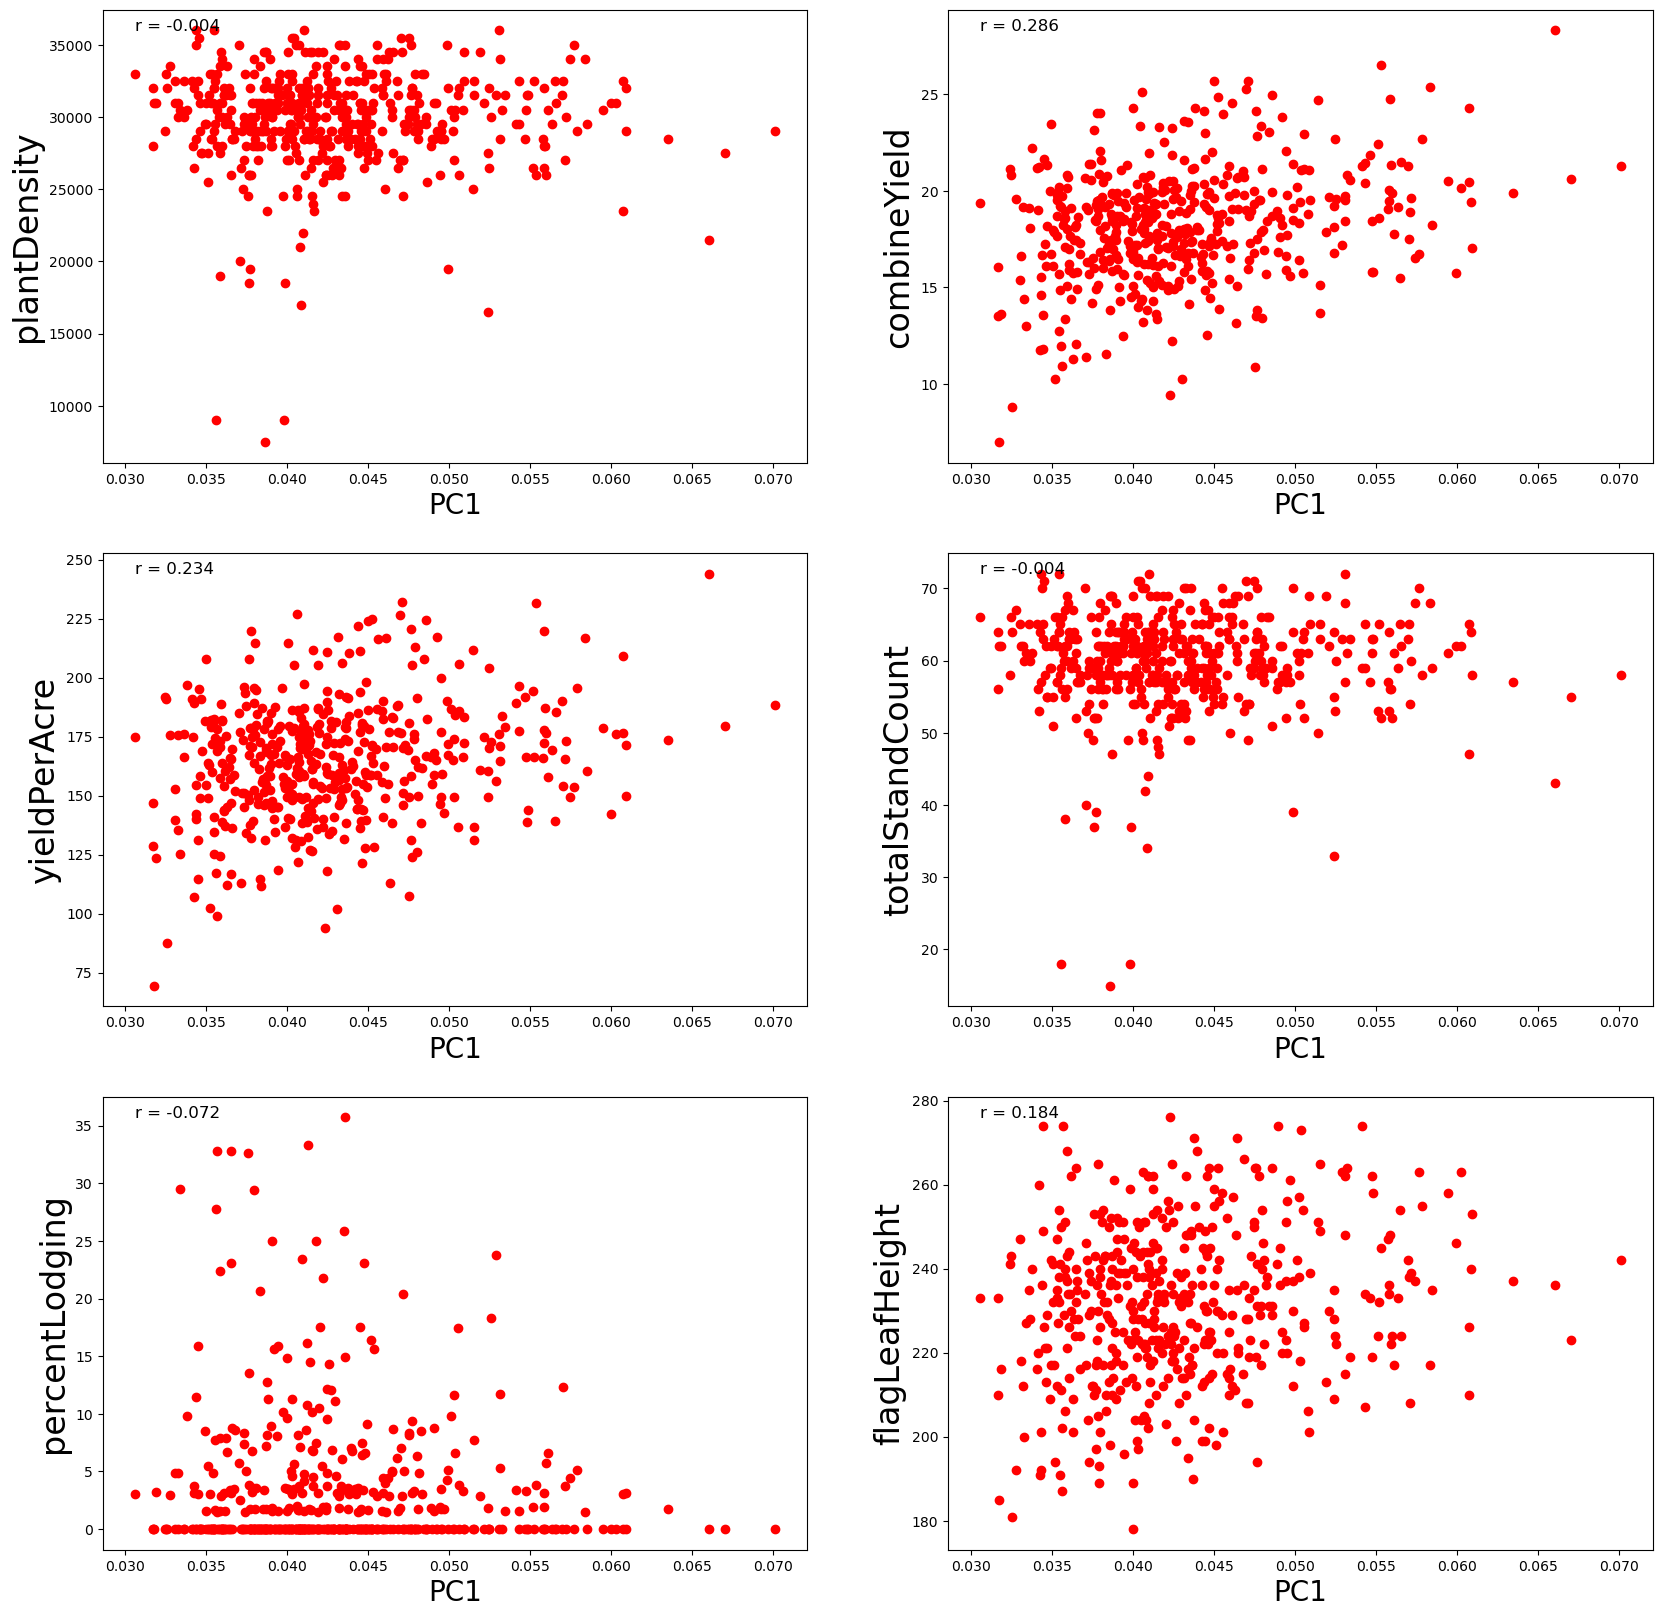

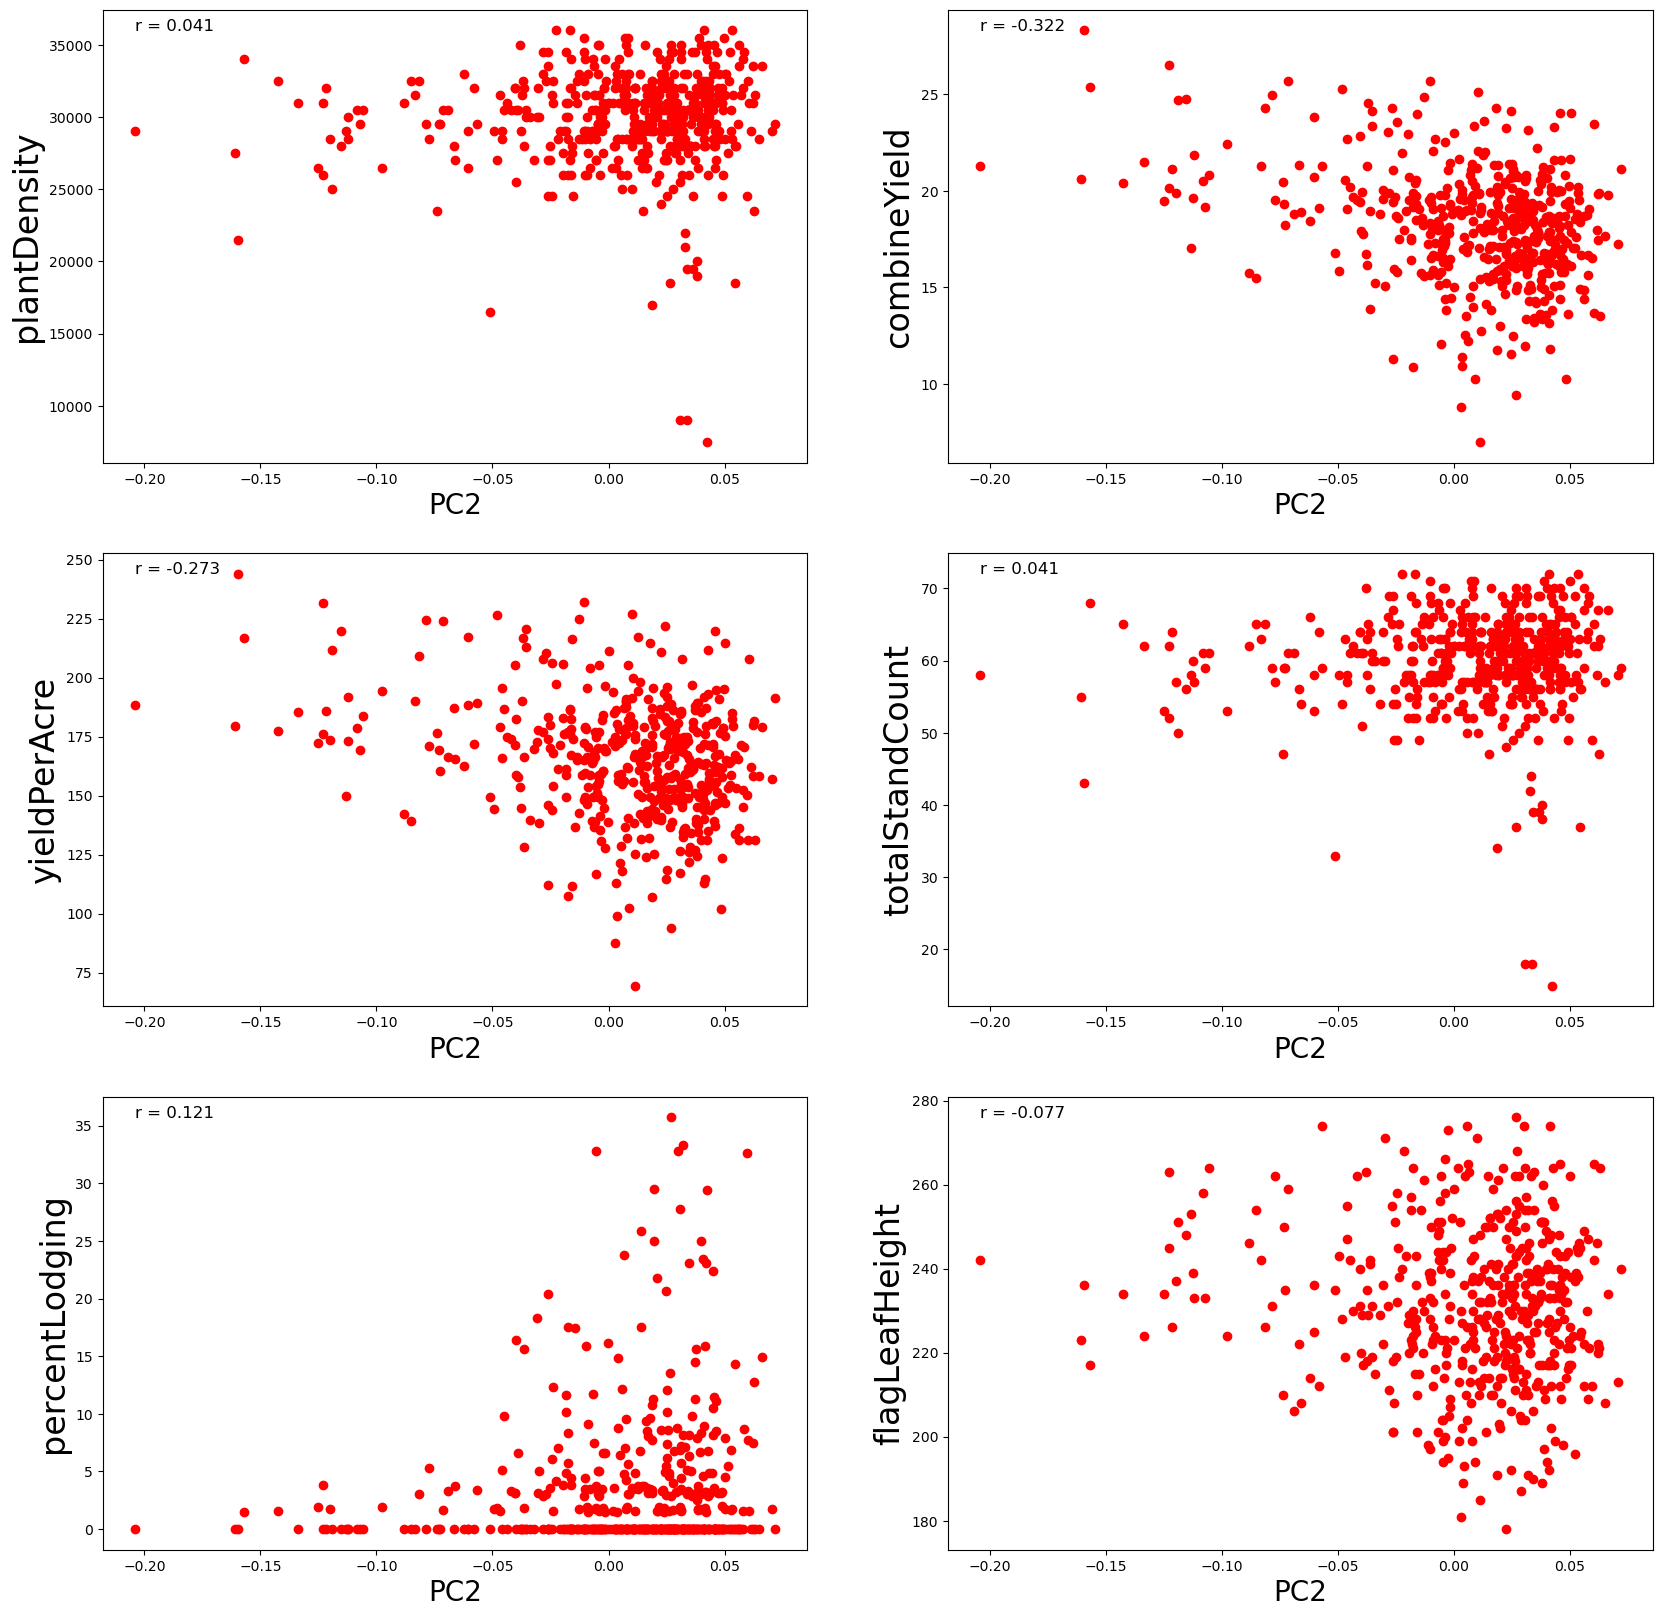

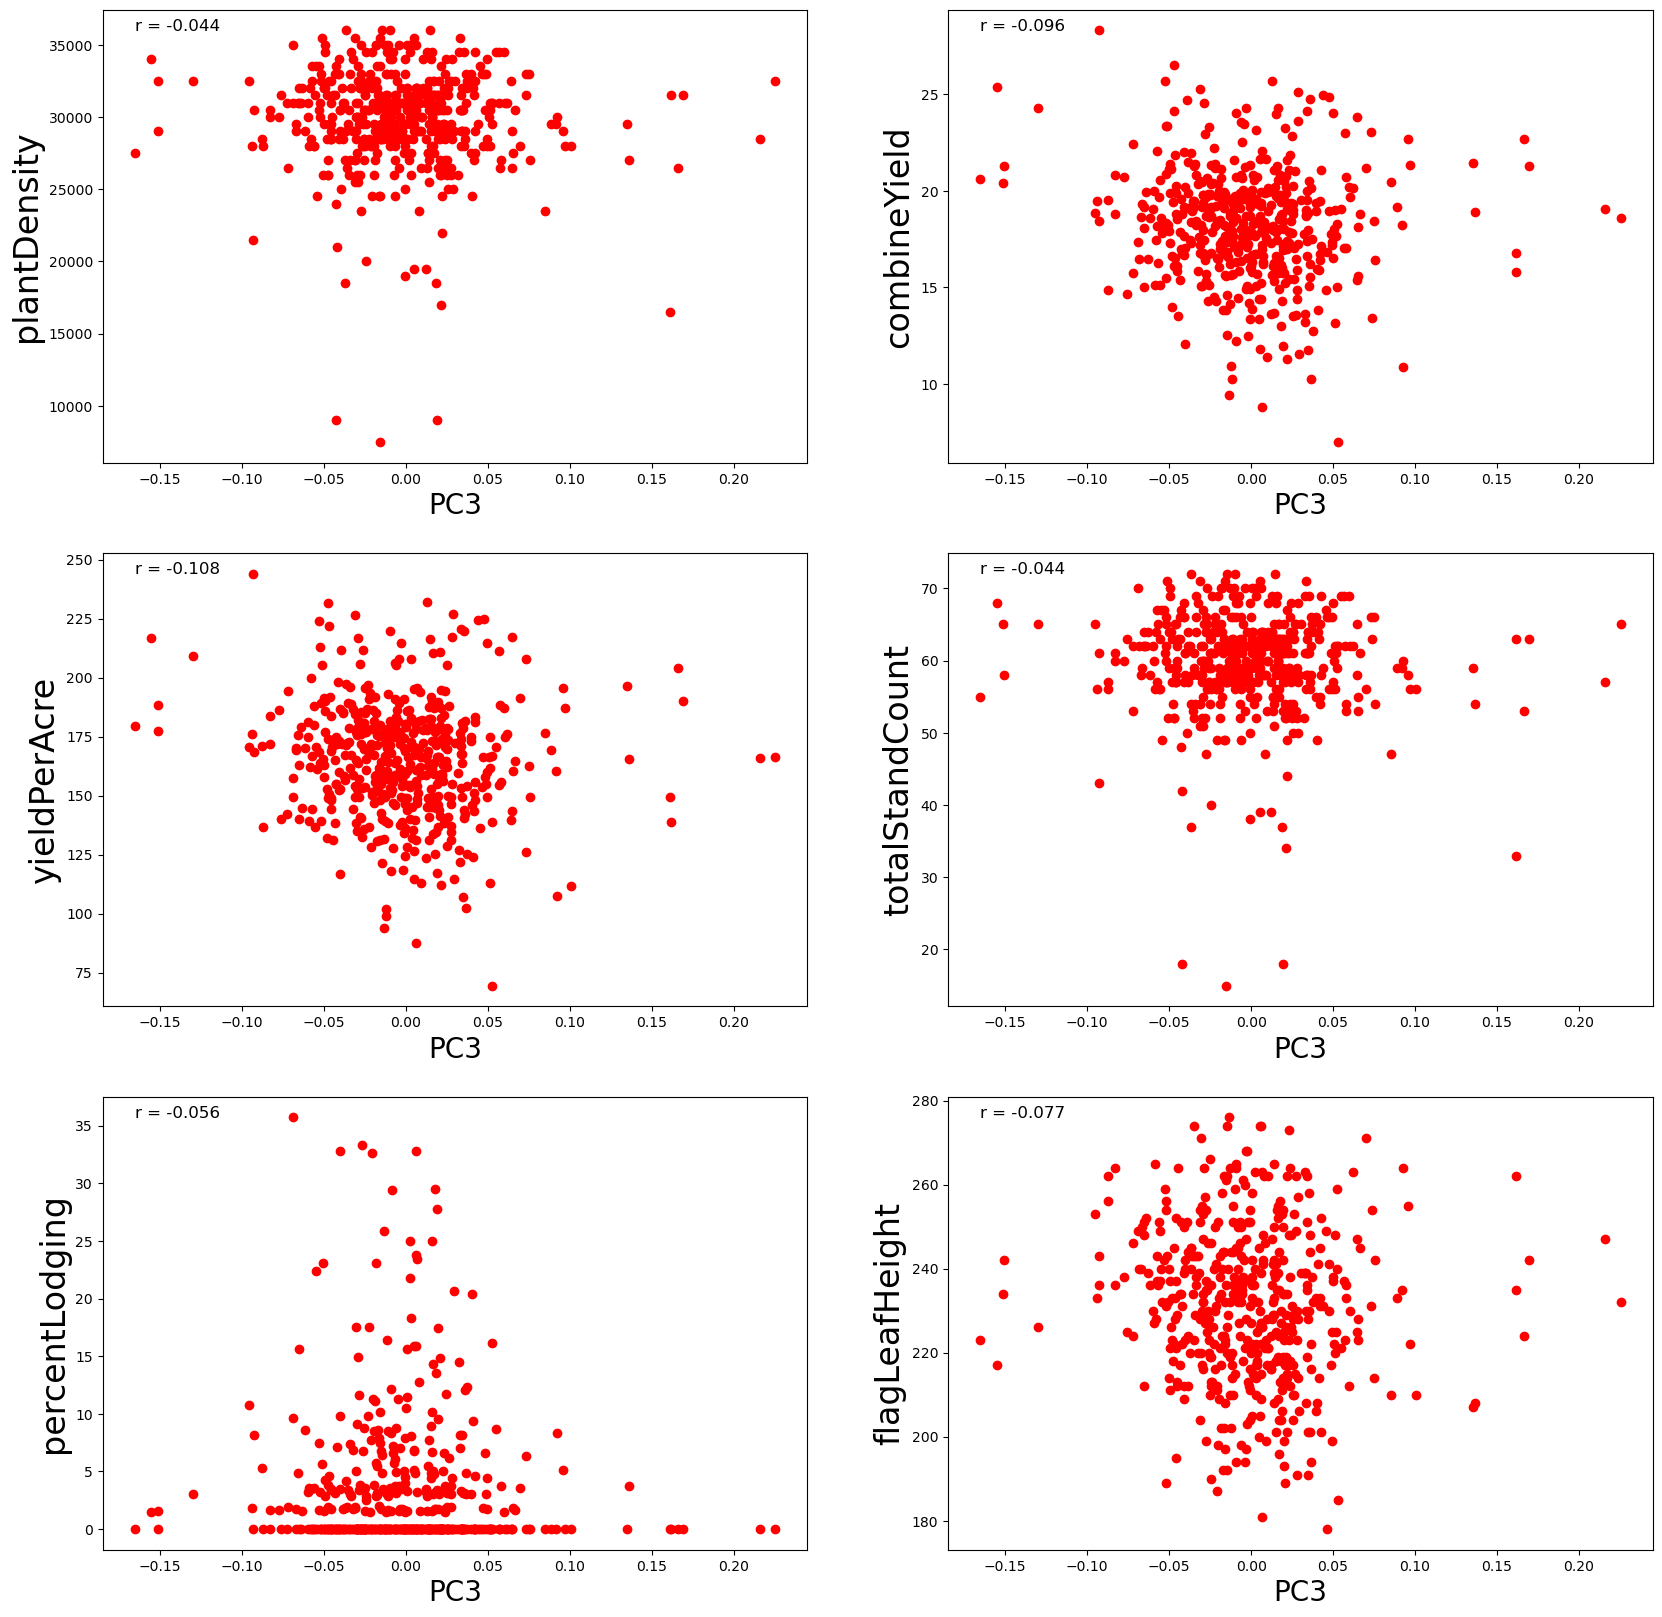

In [288]:
bands=['Red','Green','Blue', 'NIR', 'RedEdge', 'DeepBlue','PC1', 'PC2', 'PC3']
for band in bands:
    fig = plt.figure(figsize=(20,20))
    num=1
    for i in new_column_names:
        myax=fig.add_subplot(3,2,num)
        
        RGBvalues_plotting=RGBvalues[[band, i]]
        RGBvalues_plotting=RGBvalues_plotting.dropna()
        
        myax.scatter(RGBvalues_plotting[band], RGBvalues_plotting[i], color='red', alpha=1)
        
        r, pval = pearsonr(RGBvalues_plotting[band].tolist(),RGBvalues_plotting[i].tolist())
        r2 =r**2
        myax.annotate("r = {:.3f}".format(r), (min(RGBvalues_plotting[band]), max(RGBvalues_plotting[i])), size=12)
        
        print(band)
        myax.set_xlabel(band,size=20)
        myax.set_ylabel(i, fontsize=24)

        if num==6: break
        num+=1
    plt.savefig("../NNSatelliteImages/Plots/"+band+"_"+TP+"_Crawfordsville.png")

In [273]:
from scipy.stats import pearsonr
r, pval = pearsonr(RGBvalues_plotting[band].tolist(),RGBvalues_plotting[i].tolist())
r2 =r**2
print(r2)

0.004150579909128502


In [274]:
# y_true_valid = RGBvalues_plotting[band][valid_indices]
# y_pred_valid = RGBvalues_plotting[i][valid_indices]
r2_score(RGBvalues_plotting[band].tolist(),RGBvalues_plotting[i].tolist())

-27796585.50205533

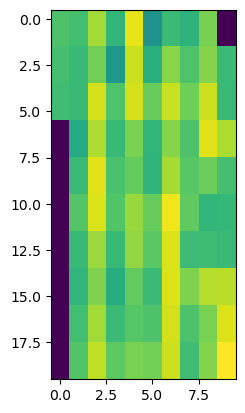

In [67]:
with rasterio.open("/home/schnablelab/Documents/NNSatelliteImages/SixBndImages/Scottsbluff/Hybrids/TP2/Scottsbluff-TP2-n150_10_16_cropped.tif", 'r') as img:
    data=img.read()
img.count
plt.imshow(data[2])

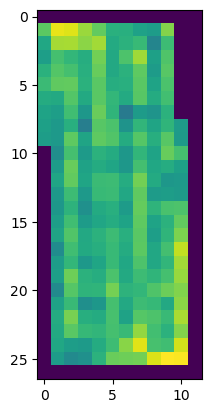

In [76]:
with rasterio.open("/home/schnablelab/Documents/NNSatelliteImages/SixBndImages/Scottsbluff/Hybrids/TP2/Scottsbluff-TP2-n150_10_16.TIF", 'r') as img:
    data=img.read()
    red=img.read(1)
    green=img.read(2)
    blue=img.read(3)
    
    
img.count
plt.imshow(data[2])

('Pleiades NEO Red (0.618 - 0.689) um', 'Pleiades NEO Green (0.533 - 0.59) um', 'Pleiades NEO Blue (0.446 - 0.52) um', 'Pleiades NEO NIR (0.768 - 0.888) um', 'Pleiades NEO Red Edge (0.696 - 0.749) um', 'Pleiades NEO Deep Blue (0.416 - 0.456) um')


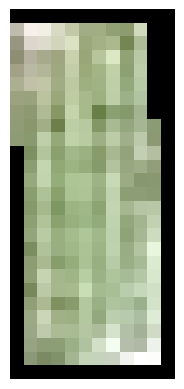

In [118]:
from rasterio.plot import show_hist

def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

with rasterio.open("/home/schnablelab/Documents/NNSatelliteImages/SixBndImages/Scottsbluff/Hybrids/TP2/Scottsbluff-TP2-n150_10_16.TIF", 'r') as src:
    # show_hist(
    #     img, bins=50, lw=0.0, stacked=False, alpha=0.3,
    #     histtype='stepfilled', title="Histogram")
    # rasterio.plot.show(src.read([1,2,3]))
    S_images=src.read()
    b2 = norm(S_images[0].astype(np.float32))
    b3 = norm(S_images[1].astype(np.float32))
    b4 = norm(S_images[2].astype(np.float32))

    # Create RGB
    rgb = np.dstack((b4,b3,b2))

    # Visualize RGB
   
    plt.imshow(rgb)
    plt.axis('off')
    plt.savefig("exampleimage.png", dpi=300, bbox_inches='tight', pad_inches=0)
    print(src.descriptions)
    
    
   
    

In [68]:
import rasterio.plot as rp

def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

arr = np.arange(255, dtype=np.float32)
print(np.all(rp.adjust_band(arr) == norm(arr)))
True

True


True

In [22]:
data[3]

array([[   0, 4509, 4452, 3983, 4382, 4368, 3779, 3644, 3658, 3647, 3952,
           0],
       [   0, 4386, 4545, 4110, 4111, 4366, 3678, 3565, 3744, 3713, 4288,
           0],
       [   0, 4254, 4583, 4775, 4920, 4905, 4406, 4318, 4346, 4418, 4772,
           0],
       [   0, 4390, 4398, 4742, 4923, 4628, 4315, 4407, 4706, 4460, 4100,
           0],
       [   0, 4355, 4441, 4592, 4655, 4672, 4421, 4524, 4804, 4315, 3907,
           0],
       [   0, 4479, 4797, 4600, 4310, 5049, 5319, 5069, 4725, 4364, 4396,
           0],
       [   0, 4523, 4664, 4549, 4463, 4780, 4895, 4851, 4844, 4745, 4646,
           0],
       [   0, 4647, 4922, 4953, 4863, 4651, 4644, 4808, 4978, 4943, 4808,
           0],
       [   0, 5074, 5031, 5010, 4762, 4926, 5087, 4909, 4729, 4704, 4875,
           0],
       [   0, 4359, 4558, 4805, 4298, 5198, 5226, 4711, 4606, 4695, 4844,
           0],
       [   0, 4119, 4602, 4621, 4207, 4780, 4927, 4671, 4648, 4695, 4861,
           0],
       [   0, 4728, 4

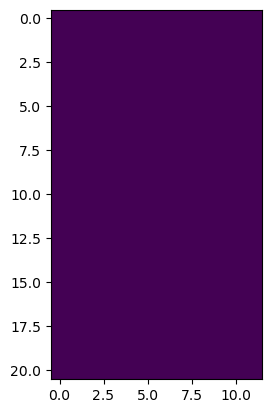

In [32]:
original_image = np.random.random((data.shape[1], data.shape[2])).astype(np.uint16)
depth_map = np.full_like(original_image, 100)
plt.imshow(depth_map)

<class 'numpy.ndarray'>
(242,)


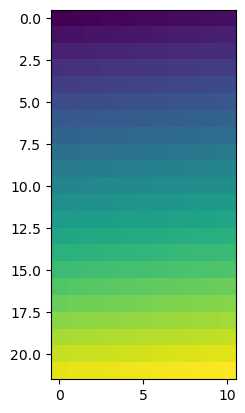

In [46]:
array = np.arange(0, 242, 1, np.uint16) 

# check type of array 
print(type(array)) 

# our array will be of width  
# 737280 pixels That means it  
# will be a long dark line 
print(array.shape) 

# Reshape the array into a  
# familiar resoluition 
array = np.reshape(array, (22, 11)) 

plt.imshow(array)

In [39]:
array.shape

(1024, 720)

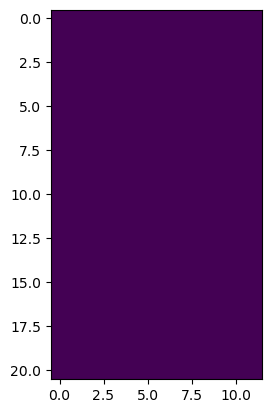

In [34]:
plt.imshow(depth_map, interpolation='nearest')
plt.show()